# Best Algorithm

This notebook will test several algorithms and compare their performance. Afterwards, the best algorithm will be trained with different parameters.

We will use the 18 previous hours to train the models in the first phase. We will also only use one location, for faster development.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12.8, 7.2)

import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

# import XGBoost
import xgboost as xgb

# import Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

# import Artificial Neural Network
from sklearn.neural_network import MLPRegressor

# import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [2]:
df = pd.read_pickle("df4.pkl")
df.head()


,energy,temp,rhum,wspd,pres,energy_1,energy_2,energy_3,energy_4,energy_5,...,energy_39,energy_40,energy_41,energy_42,energy_43,energy_44,energy_45,energy_46,energy_47,energy_48
78994,0.08,16.6,57.5,11.2,1010.70,0.08,0.08,0.08,0.08,0.08,...,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08,0.07,0.08
79002,0.08,17.6,52.0,11.2,1010.60,0.08,0.08,0.08,0.08,0.08,...,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08,0.07
79011,0.08,16.6,59.5,13.0,1010.45,0.08,0.08,0.08,0.08,0.08,...,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08
79028,0.08,15.6,65.0,12.1,1010.25,0.08,0.08,0.08,0.08,0.08,...,0.56,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07
79037,0.08,15.6,63.0,9.4,1010.20,0.08,0.08,0.08,0.08,0.08,...,0.91,0.56,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07


In [3]:
def pre_processing(df: pd.DataFrame, X_columns, y_columns, random=True, test_size=0.2):
    """Pre-processing function

    This function takes a dataframe and splits it into X and y.
    It also splits the data into train and test.

    Args:
        df: pandas dataframe
        X_columns: list of columns to be used as X
        y_columns: list of columns to be used as y
        random: boolean, if True, randomize the dataframe
        test_size: float, the size of the test set

    Returns:
        X_train: numpy array of X_train
        X_test: numpy array of X_test
        y_train: numpy array of y_train
        y_test: numpy array of y_test
    """
    X = df[X_columns]
    y = df[y_columns]

    if random:
        # split into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
    else:
        # get first train size of data as train
        X_train = X.iloc[: int(X.shape[0] * (1 - test_size))]
        y_train = y.iloc[: int(y.shape[0] * (1 - test_size))]
        # get remaining data as test
        X_test = X.iloc[int(X.shape[0] * (1 - test_size)) :]
        y_test = y.iloc[int(y.shape[0] * (1 - test_size)) :]

    return X_train, X_test, y_train, y_test


def plot_results(preds: np.array, actuals: np.array, title: str):
    """Plotting function

    This function plots the predicted and actual values.

    Args:
        preds: numpy array of predicted values
        actuals: numpy array of actual values
    """
    plt.scatter(actuals, preds, c="b", label="predicted")
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], "--r", label="y=x")
    plt.legend()
    plt.show()


def performance_metrics(preds: np.array, actuals: np.array):
    """Performance metrics function

    This function calculates the performance metrics.

    Args:
        preds: numpy array of predicted values
        actuals: numpy array of actual values
    """
    # calculate performance metrics
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    wmape = np.sum(np.abs(actuals - preds)) / np.sum(np.abs(actuals))
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print("MSE: %.4f" % mse)
    print("RMSE: %.4f" % rmse)
    print("MAE: %.4f" % mae)
    print("WMAPE: %.4f" % wmape)
    print("R2: %.4f" % r2)


In [4]:
X_train, X_test, y_train, y_test = pre_processing(
    df,
    X_columns=[f"energy_{i}" for i in range(1, 37)],
    y_columns=["energy"],
    random=True,
    test_size=0.2,
)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

for i in range(5):
    print(X_train[i], y_train[i])


[5.2 5.  5.1 5.2 5.3 5.3 5.2 5.1 5.1 5.  5.2 5.1 5.  4.5 4.4 4.1 4.1 4.2
 4.2 4.  4.7 5.7 5.6 5.2 6.2 5.8 5.7 5.8 5.7 5.7 5.6 5.8 5.7 5.7 5.8 5.7] [5.2]
[0.55 0.56 0.54 0.51 0.46 0.39 0.73 0.85 0.82 0.77 0.75 0.75 0.9  0.72
 0.89 0.71 0.71 0.68 0.7  0.72 0.78 0.68 0.68 0.69 0.67 0.69 0.76 0.66
 0.62 0.64 0.63 0.65 0.73 0.58 0.54 0.53] [0.58]
[ 1.688  1.473  1.535  1.4    2.845  4.849  4.032  4.833  5.492  6.186
  7.559  8.018 12.562 13.18  11.089 12.348 10.345 10.611  1.     1.164
  1.192  1.462  1.115  1.008  1.308  1.027  1.336  1.094  1.232  0.954
  1.011  1.291  1.07   1.299  1.042  1.033] [1.633]
[1.56  1.543 1.548 1.535 1.567 1.575 1.539 1.546 1.573 1.56  1.569 1.533
 1.569 1.572 1.567 1.556 1.533 1.571 1.573 1.606 1.85  1.485 1.522 1.574
 1.71  4.207 4.985 5.084 5.553 5.721 5.766 5.911 6.084 5.913 5.795 5.869] [1.532]
[0.098 0.101 0.098 0.1   0.099 0.078 0.005 0.004 0.005 0.005 0.005 0.005
 0.004 0.005 0.005 0.005 0.004 0.005 0.004 0.004 0.005 0.034 0.099 0.1
 0.101 0.101 0.1   

## LSTM

Train an LSTM model with the last 18 hours of the data.

In [6]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)


In [6]:
from keras.layers import CuDNNLSTM


def create_lstm_model(X):
    """
    Build an LSTM model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: LSTM model
    """
    # define model
    model = Sequential()
    model.add(LSTM(5, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(5))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    return model


In [7]:
lstm_model = create_lstm_model(X_train)


In [8]:
# fit model
lstm_model.fit(X_train, y_train, epochs=12, batch_size=1000)


Epoch 1/12
4022/4022 [==============================] - 179s 44ms/step - loss: 34.2890 - mse: 34.2890
Epoch 2/12
4022/4022 [==============================] - 156s 39ms/step - loss: 7.5385 - mse: 7.5385
Epoch 3/12
4022/4022 [==============================] - 168s 42ms/step - loss: 2.8081 - mse: 2.8081
Epoch 4/12
4022/4022 [==============================] - 189s 47ms/step - loss: 2.1986 - mse: 2.1986
Epoch 5/12
4022/4022 [==============================] - 213s 53ms/step - loss: 2.1086 - mse: 2.1086
Epoch 6/12
4022/4022 [==============================] - 175s 43ms/step - loss: 2.0708 - mse: 2.0708
Epoch 7/12
4022/4022 [==============================] - 179s 44ms/step - loss: 2.0509 - mse: 2.0509
Epoch 8/12
4022/4022 [==============================] - 181s 45ms/step - loss: 2.0369 - mse: 2.0369
Epoch 9/12
4022/4022 [==============================] - 177s 44ms/step - loss: 2.0241 - mse: 2.0241
Epoch 10/12
4022/4022 [==============================] - 178s 44ms/step - loss: 2.0156 - mse: 2.01

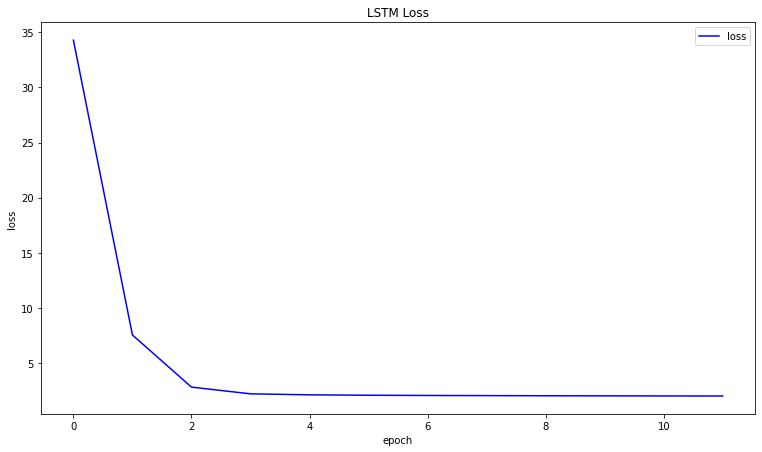

In [9]:
# plot loss
plt.plot(lstm_model.history.history["loss"], c="b")
plt.title("LSTM Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss"])
plt.show()


In [10]:
# make predictions
preds = lstm_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
# preds = scaler.inverse_transform(preds)


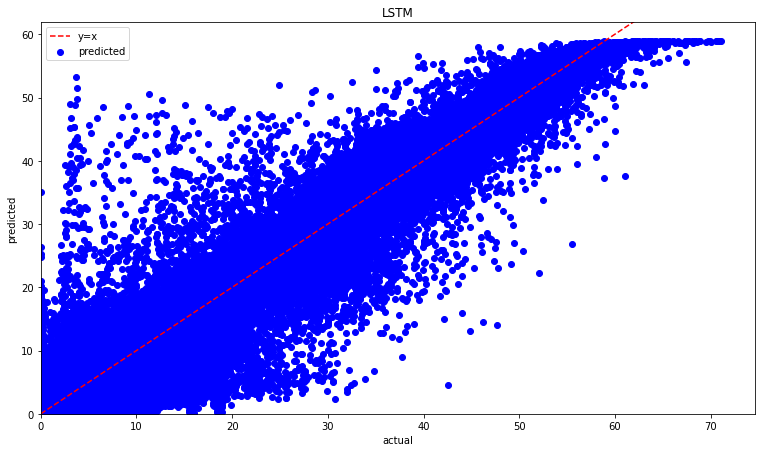

In [11]:
# plot results
plot_results(preds, y_test, "LSTM")


In [12]:
# performance metrics
performance_metrics(preds, y_test)


MSE: 1.9852
RMSE: 1.4090
MAE: 0.5596
WMAPE: 0.1375
R2: 0.9728


## ANN

Train the ANN model with the last 5 hours of the data.

In [7]:
def create_ann_model(X):
    """
    Build an ANN model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: ANN model
    """
    # define model
    model = Sequential()
    model.add(Dense(10, input_dim=X.shape[1], activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    return model


In [10]:
ann_model = create_ann_model(X_train)


In [11]:
# fit model
ann_model.fit(X_train, y_train, epochs=20, batch_size=1000)


Epoch 1/20
4022/4022 [==============================] - 8s 2ms/step - loss: 2.6053 - mse: 2.6053
Epoch 2/20
4022/4022 [==============================] - 6s 2ms/step - loss: 2.0237 - mse: 2.0237
Epoch 3/20
4022/4022 [==============================] - 7s 2ms/step - loss: 1.9965 - mse: 1.9965
Epoch 4/20
4022/4022 [==============================] - 7s 2ms/step - loss: 1.9736 - mse: 1.9736
Epoch 5/20
4022/4022 [==============================] - 7s 2ms/step - loss: 1.9613 - mse: 1.9613
Epoch 6/20
4022/4022 [==============================] - 9s 2ms/step - loss: 1.9443 - mse: 1.9443
Epoch 7/20
4022/4022 [==============================] - 8s 2ms/step - loss: 1.9281 - mse: 1.9281
Epoch 8/20
4022/4022 [==============================] - 8s 2ms/step - loss: 1.9177 - mse: 1.9177
Epoch 9/20
4022/4022 [==============================] - 10s 2ms/step - loss: 1.9110 - mse: 1.9110
Epoch 10/20
4022/4022 [==============================] - 8s 2ms/step - loss: 1.9079 - mse: 1.9079
Epoch 11/20
4022/4022 [=====

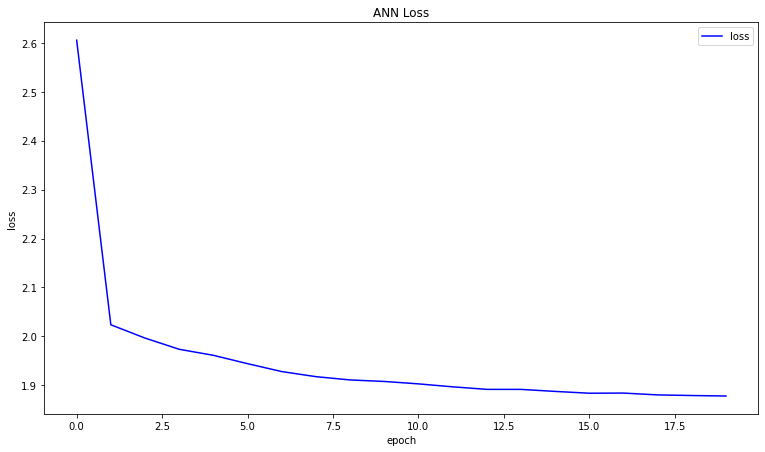

In [12]:
# plot loss
plt.plot(ann_model.history.history["loss"], c="b")
plt.title("ANN Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss"])
plt.show()


In [13]:
# make predictions
preds = ann_model.predict(X_test)


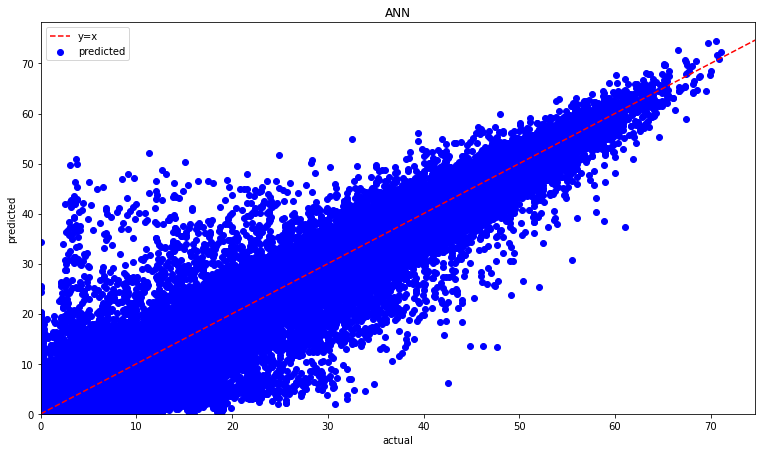

In [14]:
# plot results
plot_results(preds, y_test, "ANN")


In [15]:
# performance metrics
performance_metrics(preds, y_test)


MSE: 1.8540
RMSE: 1.3616
MAE: 0.5092
WMAPE: 0.1251
R2: 0.9746


## Gradient Boosting

Train the Gradient Boosting model with the last 5 hours of the data.

In [5]:
def create_gbdt_model():
    """
    Build an GBDT model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: GBDT model
    """
    # define model
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
    return model


In [6]:
gbdt_model = create_gbdt_model()


In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])


In [8]:
gbdt_model.fit(X_train, y_train)


GradientBoostingRegressor()

In [9]:
# make predictions
preds = gbdt_model.predict(X_test)


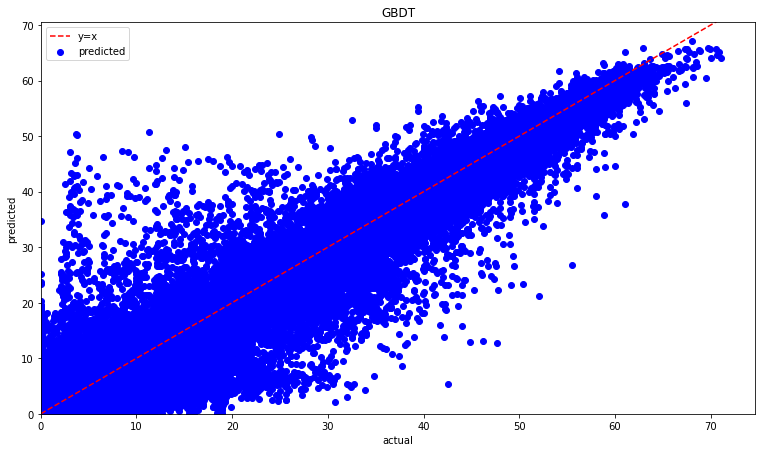

In [10]:
# plot results
plot_results(preds, y_test, "GBDT")


In [11]:
# performance metrics
performance_metrics(preds, y_test)


MSE: 1.9174
RMSE: 1.3847
MAE: 0.5266
WMAPE: 0.1294
R2: 0.9738


## XGBoost

Apply the XGBoost model with the last 18 hours of the data.

In [12]:
def create_xgboost_model():
    """
    Build an XGBoost model

    Args:
        X: pandas dataframe or numpy array, containing the data to train

    Returns:
        model: XGBoost model
    """
    # define model
    model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42)
    return model


In [13]:
xgboost_model = create_xgboost_model()


In [14]:
xgboost_model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=1)

In [15]:
preds = xgboost_model.predict(X_test)


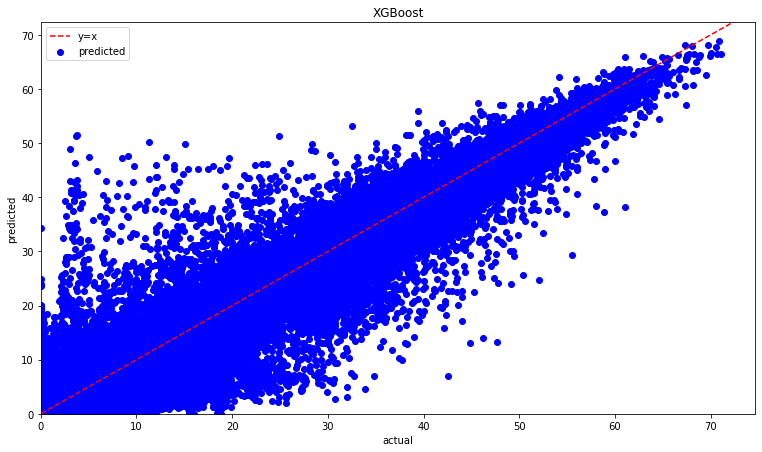

In [16]:
# plot results
plot_results(preds, y_test, "XGBoost")


In [17]:
# performance metrics
performance_metrics(preds, y_test)


MSE: 1.7771
RMSE: 1.3331
MAE: 0.5048
WMAPE: 0.1241
R2: 0.9757
